In [1]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

## Part 1: Import dataset

In [2]:
# Read in full dataset
news = pd.read_csv('truefake.csv')

In [3]:
# See head of dataframe
news.head()

,r_or_f,title,text,subject,date
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [4]:
# There are some duplicates or null values!
news.describe().transpose()

,count,unique,top,freq
r_or_f,44919,2,Fake,23502
title,44919,38740,Factbox: Trump fills top jobs for his administ...,14
text,44919,38657,,627
subject,44898,19,politicsNews,11272
date,44898,1027,20-Dec-17,197


In [5]:
# Dropped null values, title-only rows, and duplicates
news.dropna(inplace=True)
news = news[news.text != ' ']
news = news.drop_duplicates(subset='text', keep='last')

In [3]:
# Remove non-ascii characters
def no_ascii(text):
    return (re.sub(r'[^\x00-\x7f]',r'', text))

In [7]:
news['text'] = news['text'].apply(no_ascii)

In [8]:
news.describe().transpose()

,count,unique,top,freq
r_or_f,38645,2,Real,21191
title,38645,38269,Factbox: Trump fills top jobs for his administ...,14
text,38645,38645,WASHINGTON (Reuters) - The head of a conservat...,1
subject,38645,19,politicsNews,11202
date,38645,1027,6-Dec-17,177


## Part 2: Feature Extraction 1: Word length, capitalization

Test a variety of features to see what is best correlated to real/fake

In [9]:
# Character length
news['char_length'] = news['text'].apply(len)

In [10]:
# Word length; drop single value with 0 word_length
news['word_length'] = news['text'].apply(lambda x: len(x.split()))
news = news[news['word_length'] != 0]

In [11]:
# Average char/word
news['avg_char_word'] = news['char_length'] / news['word_length']

In [4]:
# Capital letters function
def num_capital_letters(text):
    result = 0
    for i in text:
        if i.isupper():
            result += 1
    return result

In [13]:
# Capital letters
news['capital_per_word_length'] = news['text'].apply(num_capital_letters) / news['word_length']

In [14]:
news.head()

,r_or_f,title,text,subject,date,char_length,word_length,avg_char_word,capital_per_word_length
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,4625,749,6.174900,0.206943
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,4053,624,6.495192,0.190705
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,2771,457,6.063457,0.256018
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,2449,376,6.513298,0.292553
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,5186,852,6.086854,0.234742


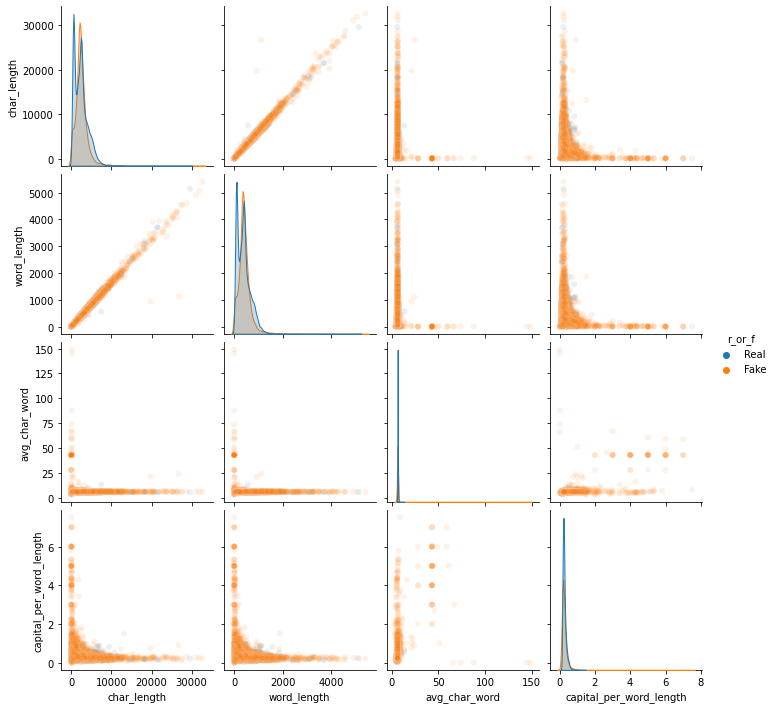

In [15]:
# Let's get a sense of the correlation with a pairplot
# Not a lot of visible separation here, though there are some shorter real articles
sns.pairplot(news,hue='r_or_f',plot_kws={'alpha': 0.1})

## Part 3: Feature Extraction 2: Punctuation marks

In [5]:
import string

In [17]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [6]:
# General number of punctuation
def all_punc_count(text):
    result = 0
    for i in text:
        if i in string.punctuation:
            result += 1
    return result

In [19]:
# Punc per word length
news['all_punc_count_word'] = news['text'].apply(all_punc_count) / news['word_length']

In [20]:
news.head()

,r_or_f,title,text,subject,date,char_length,word_length,avg_char_word,capital_per_word_length,all_punc_count_word
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,4625,749,6.174900,0.206943,0.157543
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,4053,624,6.495192,0.190705,0.123397
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,2771,457,6.063457,0.256018,0.102845
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,2449,376,6.513298,0.292553,0.135638
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,5186,852,6.086854,0.234742,0.159624


In [7]:
# For specific puncs
def punc_occurences(text, punc_mark, word_length):
    result = 0
    for i in text:
        if i == punc_mark:
            result += 1
    return result / word_length

In [22]:
# Specific puncs
for punc_mark in string.punctuation:
    news[punc_mark] = news.apply(lambda x: punc_occurences(x['text'],punc_mark,x['word_length']), axis=1)

In [23]:
news.head()

,r_or_f,title,text,subject,date,char_length,word_length,avg_char_word,capital_per_word_length,all_punc_count_word,...,[,\,],^,_,`,{,|,},~
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,4625,749,6.174900,0.206943,0.157543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,4053,624,6.495192,0.190705,0.123397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,2771,457,6.063457,0.256018,0.102845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,2449,376,6.513298,0.292553,0.135638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,5186,852,6.086854,0.234742,0.159624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Example where there is some punctuation
news[news['!'] != 0][['title','word_length','!']].head()

,title,word_length,!
4,Trump wants Postal Service to charge 'much mor...,852,0.001174
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,133,0.015038
8,Trump on Twitter (Dec 28) - Global Warming,98,0.020408
12,Factbox: Trump on Twitter (Dec 28) - Vanity Fa...,97,0.010309
13,"Trump on Twitter (Dec 27) - Trump, Iraq, Syria",190,0.005263


## Part 4: Feature Extraction 3: Stopwords
Is there a correlation with the proportion of stopwords?

In [8]:
from nltk.corpus import stopwords

In [9]:
def stopword_count(text, word_length):
    result = 0
    for word in text.lower().split():
        if word in stopwords.words('english'):
            result += 1
    return result / word_length

In [27]:
news['stopword_ratio'] = news.apply(lambda x: stopword_count(x['text'],x['word_length']), axis=1)

In [28]:
news.head()

,r_or_f,title,text,subject,date,char_length,word_length,avg_char_word,capital_per_word_length,all_punc_count_word,...,\,],^,_,`,{,|,},~,stopword_ratio
0,Real,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,4625,749,6.174900,0.206943,0.157543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384513
1,Real,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,4053,624,6.495192,0.190705,0.123397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379808
2,Real,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,2771,457,6.063457,0.256018,0.102845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411379
3,Real,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,2449,376,6.513298,0.292553,0.135638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380319
4,Real,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,5186,852,6.086854,0.234742,0.159624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395540


In [29]:
# Let's see what a full row looks like!
for i,j in news.head(1).iterrows():
    print(i,j)

0 r_or_f                                                                  Real
title                      As U.S. budget fight looms, Republicans flip t...
text                       WASHINGTON (Reuters) - The head of a conservat...
subject                                                         politicsNews
date                                                               31-Dec-17
char_length                                                             4625
word_length                                                              749
avg_char_word                                                         6.1749
capital_per_word_length                                             0.206943
all_punc_count_word                                                 0.157543
!                                                                        0.0
"                                                                        0.0
#                                                                        0

In [34]:
# Correlation of all feature columns to real/fake
# How correlated are the features to being real or fake?
# Correlation of all feature columns to real/fake
# How correlated are the features to being real or fake?
abs(news[news.columns[4:]].corr()['real_0_fake_1'][:-1]).sort_values(ascending=False)

stopword_ratio             0.434213
@                          0.220587
(                          0.138323
!                          0.137431
)                          0.136638
:                          0.128641
%                          0.099310
#                          0.094783
?                          0.082624
"                          0.080606
word_length                0.061387
/                          0.057453
all_punc_count_word        0.048495
'                          0.048084
[                          0.046935
capital_per_word_length    0.046512
<                          0.044548
char_length                0.042312
]                          0.041437
=                          0.040691
|                          0.035662
>                          0.033248
;                          0.030306
_                          0.028561
,                          0.027499
~                          0.027173
&                          0.026832
$                          0

Text(0.5, 1.0, 'Proportion of Stopwords')

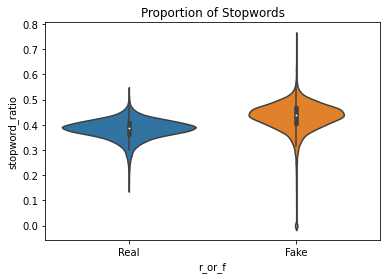

In [35]:
# We can see that fake news articles have generally more stopwords
sns.violinplot(x='r_or_f', y='stopword_ratio',data=news)
plt.title('Proportion of Stopwords')

In [33]:
# Save dataframe into a csv
# news.to_csv('fullrnnfeatures.csv',encoding='utf-8',index=False)

In [10]:
# Load in df
# news = pd.read_csv('fullrnnfeatures.csv')

## Part 5: Train test split, scaling
70-30% train test split, minmaxscaler to scale features such as word count

In [30]:
news.columns

Index(['r_or_f', 'title', 'text', 'subject', 'date', 'char_length',
       'word_length', 'avg_char_word', 'capital_per_word_length',
       'all_punc_count_word', '!', '"', '#', '$', '%', '&', ''', '(', ')', '*',
       '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\',
       ']', '^', '_', '`', '{', '|', '}', '~', 'stopword_ratio'],
      dtype='object')

In [31]:
# Turn real/fake into a dummy variable of 0 or 1
def zero_one (rf):
    if rf == "Real":
        return 0
    elif rf == "Fake":
        return 1

In [32]:
news['real_0_fake_1'] = news['r_or_f'].apply(lambda x: zero_one(x))

In [36]:
X = news.drop(['r_or_f','title','text', 'subject','date','real_0_fake_1'],axis=1).values
y = news['real_0_fake_1'].values

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [14]:
# Perform scaling post split to prevent data leakage
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
# use fit_transform to fit and transform in one line
X_train = scaler.fit_transform(X_train)

In [17]:
X_test = scaler.transform(X_test)

## Part 6: TensorFlow Model Creation
Use backpropagation and deep neural networks to create a model. Use early stopping and dropout layers to prevent overfitting.

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
# 27050 rows and 38 features, let's go with 38 layers
X_train.shape

(27050, 38)

In [49]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,
                          patience=25)

In [51]:
# Binary classification problem, use sigmoid for result layer
model = Sequential()

model.add(Dense(38,activation='relu'))
model.add(Dropout(0.5)) # Turns off half of 38 neurons each batch

model.add(Dense(19,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid')) # BINARY CLASSIFICATION

model.compile(loss='binary_crossentropy',optimizer='adam')

In [52]:
# Combine dropout layers with early stopping
# Goes a bit longer since not all neurons are being trained each epoch
model.fit(x=X_train,y=y_train,epochs=5000,validation_data=(X_test,y_test),
         callbacks=[early_stop])

2022-03-12 08:42:48.217893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-12 08:42:48.236383: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2999995000 Hz


Epoch 1/5000
846/846 [==============================] - 1s 897us/step - loss: 0.6167 - val_loss: 0.3720
Epoch 2/5000
846/846 [==============================] - 1s 783us/step - loss: 0.3325 - val_loss: 0.2243
Epoch 3/5000
846/846 [==============================] - 1s 783us/step - loss: 0.2672 - val_loss: 0.1966
Epoch 4/5000
846/846 [==============================] - 1s 786us/step - loss: 0.2404 - val_loss: 0.1825
Epoch 5/5000
846/846 [==============================] - 1s 788us/step - loss: 0.2281 - val_loss: 0.1892
Epoch 6/5000
846/846 [==============================] - 1s 777us/step - loss: 0.2200 - val_loss: 0.1683
Epoch 7/5000
846/846 [==============================] - 1s 782us/step - loss: 0.2099 - val_loss: 0.1615
Epoch 8/5000
846/846 [==============================] - 1s 789us/step - loss: 0.2052 - val_loss: 0.1570
Epoch 9/5000
846/846 [==============================] - 1s 781us/step - loss: 0.2003 - val_loss: 0.1577
Epoch 10/5000
846/846 [==============================] - 1s 780u

846/846 [==============================] - 1s 779us/step - loss: 0.1449 - val_loss: 0.1147
Epoch 80/5000
846/846 [==============================] - 1s 782us/step - loss: 0.1448 - val_loss: 0.1125
Epoch 81/5000
846/846 [==============================] - 1s 783us/step - loss: 0.1478 - val_loss: 0.1120
Epoch 82/5000
846/846 [==============================] - 1s 793us/step - loss: 0.1466 - val_loss: 0.1118
Epoch 83/5000
846/846 [==============================] - 1s 796us/step - loss: 0.1488 - val_loss: 0.1122
Epoch 84/5000
846/846 [==============================] - 1s 782us/step - loss: 0.1446 - val_loss: 0.1117
Epoch 85/5000
846/846 [==============================] - 1s 803us/step - loss: 0.1474 - val_loss: 0.1138
Epoch 86/5000
846/846 [==============================] - 1s 786us/step - loss: 0.1446 - val_loss: 0.1161
Epoch 87/5000
846/846 [==============================] - 1s 778us/step - loss: 0.1453 - val_loss: 0.1130
Epoch 88/5000
846/846 [==============================] - 1s 793us/ste

In [53]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

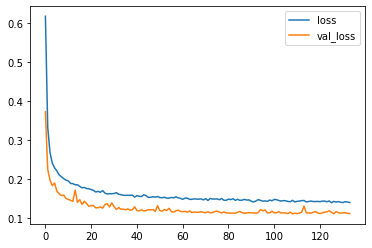

In [54]:
# Notice the green loss line stops going down but the blue still is; excess overfitting prevented
model_loss.plot()

In [55]:
# For binary models use predict_classes
predictions = model.predict_classes(X_test)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [56]:
from sklearn.metrics import classification_report,confusion_matrix

In [57]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6425
           1       0.96      0.96      0.96      5169

    accuracy                           0.96     11594
   macro avg       0.96      0.96      0.96     11594
weighted avg       0.96      0.96      0.96     11594



In [58]:
# We're trying to minimize false positives to minimize spreading fake news as real.
print(confusion_matrix(y_test,predictions))

[[6212  213]
 [ 225 4944]]


## Part 7: Predict a Novel Article

In [21]:
# Takes in raw text and creates desired numpy array
def new_art_preprocessor(text):
    res = []
    res.append(len(text)) # 0: char_length
    res.append(len(text.split())) # 1: word_length
    res.append(res[0] / res[1]) # 2: avg_char_word
    res.append(num_capital_letters(text) / res[1]) # 3: capital_per_word_length
    res.append(all_punc_count(text) / res[1]) # 4: all_punc_count_word  
    for punc in string.punctuation:
        res.append(punc_occurences(text,punc,res[1])) # 5-36: punctuations
    res.append(stopword_count(text,res[1])) # 37: stopwords
    
    art_array = pd.DataFrame(res).values
    return scaler.transform(art_array.reshape(-1,38))

In [22]:
new_art = input("Please enter article: ")
score = model.predict(new_art_preprocessor(new_art))[0][0]
real_score = round((1-score)*100.0,2)
fake_score = round((score)*100.0,2)
print(f"\nReal: {real_score}% \nFake: {fake_score}%")
print(f"Result: {'Real' if real_score > fake_score else 'Fake'}")

Please enter article: WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trumpâ€™s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administrationâ€™s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. â€œThe Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DODâ€™s study and will continue to defend the presidentâ€™s lawful authority in District Court in the meantime,â€ the offi

## Part 8: Save model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [60]:
# Save model
# model.save('fullrnnweights.h5')

In [19]:
# Load model
model = tf.keras.models.load_model('fullrnnweights.h5')